In [1]:
from scipy.io.wavfile import read, write
import torchaudio
import torch
from librosa.util import normalize
from librosa.filters import mel as librosa_mel_fn
import numpy as np
import librosa
import librosa.display
from tqdm import tqdm
import os
import soundfile as sf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
MAX_WAV_VALUE = 32768.0

def load_wav(full_path):
    sampling_rate, data = read(full_path)
    return data, sampling_rate

def dynamic_range_compression(x, C=1, clip_val=1e-5):
    return np.log(np.clip(x, a_min=clip_val, a_max=None) * C)

def dynamic_range_decompression(x, C=1):
    return np.exp(x) / C

def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)

def dynamic_range_decompression_torch(x, C=1):
    return torch.exp(x) / C

def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output

def spectral_de_normalize_torch(magnitudes):
    output = dynamic_range_decompression_torch(magnitudes)
    return output

mel_basis = {}
hann_window = {}

def mel_spectrogram(y, n_fft, num_mels, sampling_rate, hop_size, win_size, fmin, fmax, center=False):
    if torch.min(y) < -1.:
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel = librosa_mel_fn(sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax)
        mel_basis[str(fmax)+'_'+str(y.device)] = torch.from_numpy(mel).float().to(y.device)
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)

    y = torch.nn.functional.pad(y.unsqueeze(1), (int((n_fft-hop_size)/2), int((n_fft-hop_size)/2)), mode='reflect')
    y = y.squeeze(1)

    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True)

    spec = torch.sqrt(spec.pow(2).sum(-1)+(1e-9))

    spec = torch.matmul(mel_basis[str(fmax)+'_'+str(y.device)], spec)
    spec = spectral_normalize_torch(spec)

    return spec

In [3]:
from IPython.display import Audio
import pandas as pd

In [4]:
fsd50k_root_data = []
with open("/home/v-yuancwang/AudioEditing/metadatas/fsd50k_short.txt","r") as f:
    lines = f.readlines()
for line in lines:
    fsd50k_root_data.append({"file_name": line.split("   ")[0], "text": line.split("   ")[1].replace("\n", "")})
print(len(fsd50k_root_data))
esc50_root_data = []
esc50_df = pd.read_csv("/home/v-yuancwang/AudioEditing/metadatas/esc50.csv")
esc50_df =  esc50_df[["filename", "category"]].to_numpy().tolist()
for file_name, text in esc50_df:
    esc50_root_data.append({"file_name": file_name, "text": text})
print(len(esc50_root_data))

21678
2000


In [5]:
fsd50k_path = "/blob/v-yuancwang/audio_editing_data/fsd50k"
fsd50k_refine_path = "/blob/v-yuancwang/audio_editing_data/fsd50k_refine"
fsd50k_refine_set = os.listdir(os.path.join(fsd50k_refine_path, "wav"))
print(len(fsd50k_refine_set))
esc50_path = "/blob/v-yuancwang/audio_editing_data/esc50"

7329


In [6]:
file_name, text = fsd50k_root_data[12000]['file_name'], fsd50k_root_data[12000]['text']
print(file_name, text)
if file_name in fsd50k_refine_set:
    y1, sr = librosa.load(os.path.join(fsd50k_refine_path, "wav", file_name))
else:
    y1, sr = librosa.load(os.path.join(fsd50k_path, "wav", file_name))
spec1 = np.load(os.path.join(fsd50k_path, "mel", file_name.replace(".wav", ".npy")))
Audio(y1, rate=sr)

121691.wav Run


In [ ]:
plt.imshow(spec1)

In [10]:
audioset_root_data = []
audioset96_path = "/blob/v-yuancwang/audio_editing_data/audioset96"
with open("/home/v-yuancwang/AudioEditing/metadatas/audioset96_file_label.txt","r") as f:
    lines = f.readlines()
for line in lines:
    audioset_root_data.append({"file_name": line.split("   ")[0], "text": line.split("   ")[1].replace("\n", "")})
print(len(audioset_root_data))

185925


In [11]:
save_path = "/blob/v-yuancwang/audio_editing_data/add_refine"
as_refine_path = "/blob/v-yuancwang/audio_editing_data/audioset96_refine/wav"
as_refine_set = set(os.listdir(as_refine_path))
print(len(as_refine_set))
fsd50k_refine_path = "/blob/v-yuancwang/audio_editing_data/fsd50k_refine/wav"
fsd50k_refine_set = set(os.listdir(fsd50k_refine_path))
print(len(fsd50k_refine_set))

11780
7329


In [12]:
metadatas = []

for i in tqdm(range(60*1000)):
    id1 = np.random.randint(0, len(audioset_root_data))
    file_name1, text1 = audioset_root_data[id1]['file_name'], audioset_root_data[id1]['text']
    if file_name1 in as_refine_set:
        y1, sr = librosa.load(os.path.join(as_refine_path, file_name1), sr=16000)
        file_name1 = os.path.join(as_refine_path, file_name1)
    else:
        y1, sr = librosa.load(os.path.join(audioset96_path, "wav", file_name1), sr=16000)
        file_name1 = os.path.join(audioset96_path, "wav", file_name1)

    id2 = np.random.randint(0, len(fsd50k_root_data) + len(esc50_root_data))
    if id2 >= len(fsd50k_root_data):
        file_name2, text2 = esc50_root_data[id2%len(fsd50k_root_data)]['file_name'], esc50_root_data[id2%len(fsd50k_root_data)]['text']
        y2, sr = librosa.load(os.path.join(esc50_path, "wav", file_name2), sr=16000)
    else:
        file_name2, text2 = fsd50k_root_data[id2]['file_name'], fsd50k_root_data[id2]['text']
        if file_name2 in  fsd50k_refine_set:
            y2, sr = librosa.load(os.path.join(fsd50k_refine_path, file_name2), sr=16000)
            file_name2 = os.path.join(fsd50k_refine_path, file_name2)
        else:
            y2, sr = librosa.load(os.path.join(fsd50k_path, "wav", file_name2), sr=16000)
            file_name2 = os.path.join(fsd50k_path, "wav", file_name2)

    p = np.random.choice([0, 1, 2], p=[1/3,1/3,1/3])
    if p == 0:
        start = np.random.randint(int(len(y1) * 0), int(len(y1) * 0.25))
        type_c = 0
    elif p == 1:
        start = np.random.randint(int(len(y1) * 0.35), int(len(y1) * 0.5))
        type_c = 1
    else:
        start = np.random.randint(int(len(y1) * 0.6), int(len(y1) * 0.8))
        type_c = 2

    y2 = np.pad(y2, (start, max(0, len(y1) - len(y2) - start)), 'constant', constant_values=(0, 0))
    y2 = y2[: len(y1)]

    v1 = []
    v2 = []
    for j in range(0, len(y1), 1024):
        v1.append(np.mean(abs(y1[j: j+1024])))
    for j in range(0, len(y2), 1024):
        v2.append(np.mean(abs(y2[j: j+1024])))
    v1, v2 = max(v1), max(v2)
    y2 = y2 * v1 / v2

    wav3 = y1 * 0.95 + y2 * 0.75

    y3 = y1 + y2
    y3 = np.clip(y3, -1, 1)
    
    x3 = torch.FloatTensor(y3)
    x3 = mel_spectrogram(x3.unsqueeze(0), n_fft=1024, num_mels=80, sampling_rate=16000,
                    hop_size=256, win_size=1024, fmin=0, fmax=8000)
    spec3 = x3.cpu().numpy()[0]
    # print(spec3.shape)

    y3 = y3 * MAX_WAV_VALUE
    y3 = y3.astype('int16')

    # print(i)

    wav_name = 'audiosetfsdesc'  + 'gen' + str(i) + '.wav'
    spec_name = 'audiosetfsdesc'  + 'gen' + str(i) + '.npy'

    write(os.path.join(save_path, "wav", wav_name), 16000, y3)
    np.save(os.path.join(save_path, "mel", spec_name), spec3)
    metadatas.append((file_name1, file_name2, wav_name, text1, text2, type_c))

with open("/home/v-yuancwang/AudioEditing/metadatas/audioset_fsdesc.txt", "w") as f:
    for name1, name2, wav_name, text1, text2, type_c in metadatas:
        f.write(wav_name  + "   " + name1 + "   " + name2  + "   "  +  text1  + "   " +  text2 + "   " + str(type_c) + "\n")


  0%|          | 0/60000 [00:00<?, ?it/s]/opt/conda/envs/py3.7/lib/python3.7/site-packages/torch/functional.py:633: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:801.)
  normalized, onesided, return_complex)
  6%|▋         | 3837/60000 [23:08<5:25:12,  2.88it/s] 

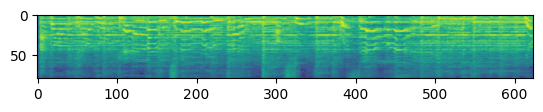

In [11]:
x1 = torch.FloatTensor(y1)
x1 = mel_spectrogram(x1.unsqueeze(0), n_fft=1024, num_mels=80, sampling_rate=16000,
                hop_size=256, win_size=1024, fmin=0, fmax=8000)
spec1 = x1.cpu().numpy()[0]
plt.imshow(spec1)

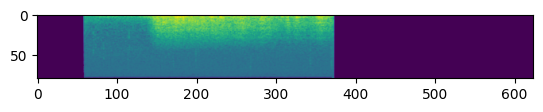

In [12]:
x2 = torch.FloatTensor(y2)
x2 = mel_spectrogram(x2.unsqueeze(0), n_fft=1024, num_mels=80, sampling_rate=16000,
                hop_size=256, win_size=1024, fmin=0, fmax=8000)
spec2 = x2.cpu().numpy()[0]
plt.imshow(spec2)

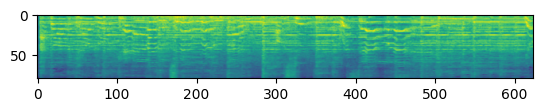

In [13]:
plt.imshow(spec3)